<a href="https://colab.research.google.com/github/AstroNoodles/Mini-Projects/blob/master/Parallel_Sync_CNN_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel Synchronous Gradient Descent CNN Research
In this notebook, I am led by graduate student Pengzhan Guo to create a synchronous CNN that can be parallelized between multiple supercomputers and is optimized by the best gradient descent networks (ADAM or RMSProp).

The CNN will be trained using the CiFAR dataset which will predict images out of 10 classes and multiple trials of the experiment will be done.

https://github.com/geifmany/cifar-vgg/blob/master/cifar10vgg.py

In [0]:
# To run Keras on any GPUs on the computer, this line must be included
#!pip3 install tensorflow-gpu
!pip3 install imageio

In [0]:
import numpy as np
import random
from imageio import imread
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib

NUM_CLASSES = 10
EPOCHS = 200
BATCH_SIZE = 128
reg_factor = 1e-06 # Regularization factor for L2 Regularization


[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]


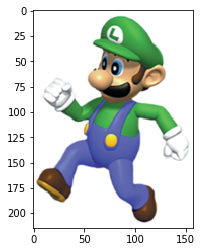

In [0]:
# DEBUG
test_img = imread('https://www.mariowiki.com/images/thumb/5/53/Luigi_Mario_Party.png/158px-Luigi_Mario_Party.png')
print(test_img[150:230])

plt.imshow(test_img)

# Retrieving the Datasets
This is the step where visualization and preprocessing is done in the CIFAR10 dataset that Keras gives us.

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("The shape of the training data is " + str(x_train.shape) + " and the shape of the labels are " + str(y_train.shape))

print(x_train)
print(y_train)

170500096/170498071 [==============================] - 6s 0us/step
The shape of the training data is (50000, 32, 32, 3) and the shape of the labels are (50000, 1)
[[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]


 [[[154 177 187]
   [126 137 136]
   [105 104  95]
   ...
   [ 91  95  71]
   [ 87  90  71]
   [ 79  81  70]]

  [[140 160 169]
   [145 153 154]
   [125 125 118]


In [0]:
# DEBUG
shape = tf.shape(x_train)

with tf.Session() as sess:
  print(sess.run(shape[:1]))
  print(sess.run(shape[1:]))
  print(sess.run(shape[:1] // 2))

[50000]
[32 32  3]
[25000]


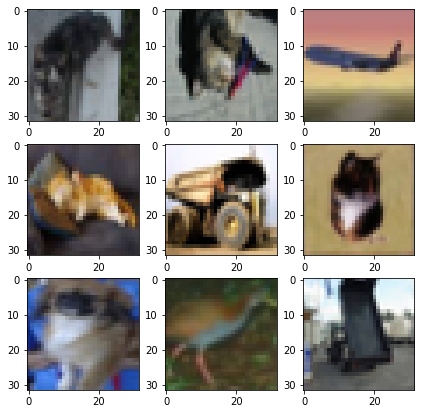

In [0]:
def visualize_cifar(train_data):
  """ Visualizes the cifar-10 dataset using matplotlib. This helps give a greater understanding
      of the items that are in the dataset"""
  plt.figure(figsize=(7, 7))
  for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(random.choice(train_data))

visualize_cifar(x_train)
CIFAR = True

## Using the Breast Cancer Dataset from [This Link](https://wiki.cancerimagingarchive.net/display/Public/Breast+Metastases+to+Axillary+Lymph+Nodes)

The strategy:
1. To identify breast cancer cells, you need to convert them into jpeg files or zip file
since they are too large.
2. !! USE ZIP FILES !!
3. Then, you need to set the CNN on the images and using the target, get the CNN to
predict the result
4. THE MAJOR PROBLEM: How do I save the images without using too much storage? (Many gigabytes and megabytes x 140)

In [0]:
import numpy as np
a = np.array([])
print(a)
a = np.append(a, [[1], 2, 3, 4, 5])
print(a)


[]
[list([1]) 2 3 4 5]


In [0]:
# The Image Data
import tarfile
import os

images = tarfile.open(name='Output1.tar.gz')
images.extractall()

found_dir = "Output"

def test_text():
  for file in os.listdir(found_dir):
    with open(found_dir + os.sep + file, 'rb') as fn:
      print(fn)
      content = fn.readlines()
      for i in content:
        print(i.decode('latin_1'))

def open_slides(slide_dir="."):
  for slide in os.listdir(slide_dir):
    if slide.endswith(".tar.gz"):
      print(slide)
      slide_dir_i = tarfile.open(slide)
      slide_dir_i.extractall(slide_dir)
  
def to_np_array(image_dir="."):
  output_arr = []
  # Note that the output files should be named 'Output#'
  # NOTE: GET ALL THE TAR FILES TO DRIVE
  for item in os.listdir(image_dir):
    if os.path.isdir(item) and 'Output' in item:
      new_dir = os.sep.join([image_dir, item])
      print(item)
      print(new_dir)
      for image in os.listdir(new_dir):
        im_array = imread(os.sep.join([new_dir, image]))
        no_alpha = np.delete(im_array, 1, axis=2)
        print(no_alpha.shape)
        output_arr.append(no_alpha)
  return np.array(output_arr)

In [0]:
# Get the training and testing data

open_slides()
X = to_np_array()
target = pd.read_csv('target.csv')
target['slide'] = target['slide'].str.replace(".svs", ".png")
test_x = X

test_target = target['target']
CIFAR = False

Output6.tar.gz
Output3.tar.gz
Output4.tar.gz
Output5.tar.gz
Output7.tar.gz
Output1.tar.gz
Output2.tar.gz
Output
./Output


NameError: ignored

In [0]:
target.hist()

NameError: ignored

In [0]:
from collections import Counter
Counter(target['target'])

NameError: ignored

[[[[244 244 255]
   [244 244 255]
   [244 244 255]
   ...
   [243 243 255]
   [243 243 255]
   [243 243 255]]

  [[244 244 255]
   [244 244 255]
   [244 244 255]
   ...
   [244 243 255]
   [244 243 255]
   [243 243 255]]

  [[244 244 255]
   [244 244 255]
   [244 244 255]
   ...
   [244 244 255]
   [244 243 255]
   [243 243 255]]

  ...

  [[244 244 255]
   [244 244 255]
   [244 244 255]
   ...
   [208 211 255]
   [204 207 255]
   [239 239 255]]

  [[244 244 255]
   [244 244 255]
   [244 244 255]
   ...
   [238 238 255]
   [244 243 255]
   [243 243 255]]

  [[244 244 255]
   [244 244 255]
   [244 244 255]
   ...
   [245 244 255]
   [243 243 255]
   [243 243 255]]]


 [[[243 243 255]
   [242 242 255]
   [243 243 255]
   ...
   [243 243 255]
   [243 243 255]
   [243 243 255]]

  [[242 242 255]
   [243 243 255]
   [242 242 255]
   ...
   [243 243 255]
   [243 243 255]
   [243 243 255]]

  [[243 243 255]
   [243 243 255]
   [243 243 255]
   ...
   [243 243 255]
   [243 243 255]
   [243 243

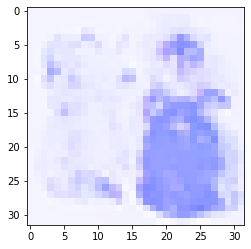

In [0]:
# Shuffle and split the data
x_train, x_test, y_train, y_test = train_test_split(test_x, test_target, test_size=.3)
print(x_train)
print()
print(y_train)

plt.imshow(x_train[0])

## Preprocessing the Data

In [0]:
def smooth_label(labels, epsillion):
  """ Adds a smooth labeling to all the one-hot encoded labels to prevent overfitting
      in the dataset: https://tinyurl.com/kerastricks"""
  if 0 <= epsillion <= 1:
    labels *= (1.0 - epsillion)
    labels += (epsillion / labels.shape[1])
  else:
    raise Exception("Label smoothing factor should be between 0 and 1. Your factor is: " + str(epsillion))
  
  return labels
  

In [0]:
def normalize_data(x_train, x_test):
  """ Normalizes the data by dividing by subtracting the mean 
      and dividing by the standard deviation. Akin to scikit-learn's
      StandardScaler."""
  mean_train, mean_test = np.mean(x_train), np.mean(x_test)
  std_train, std_test = np.std(x_train), np.std(x_test)
  return ((x_train - mean_train) / std_train, (x_test - mean_test) / std_test)
  

And now, we prepare the data for preprocessing!

In [0]:
# CIFAR
if CIFAR:
  NUM_CLASSES = 10


  x_train = x_train.astype("float32")
  x_test = x_test.astype("float32")
  print(y_train)
  x_train, x_test = normalize_data(x_train, x_test)
  y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
  y_test = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
  smooth_label(y_train, 0.2)
  print(y_train[0])

  # Preprocessing the image dataset by artificially increasing the training data size
  # via rescaling, shifting, flipping and rotating the dataset.
  data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
      featurewise_center=False,
      samplewise_center=False,
      rotation_range=0,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      width_shift_range=.1,
      height_shift_range=.1,
      horizontal_flip=True,
      vertical_flip=True)

  data_gen.fit(x_train)

In [0]:
# ONLY FOR BREAST CANCER SLIDES
NUM_CLASSES = 2
BATCH_SIZE = 32

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train, x_test = normalize_data(x_train, x_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
#smooth_label(y_train, 0.2)

print(x_train, x_train.shape, y_train, y_train.shape)

# Preprocessing the image dataset by artificially increasing the training data size
# via rescaling, shifting, flipping and rotating the dataset.
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    rotation_range=90,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    width_shift_range=.5,
    height_shift_range=.5,
    horizontal_flip=True,
    vertical_flip=True)

data_gen.fit(x_train)

[[[[ 0.2830046   0.2830046   0.6479931 ]
   [ 0.2830046   0.2830046   0.6479931 ]
   [ 0.2830046   0.2830046   0.6479931 ]
   ...
   [ 0.24982384  0.24982384  0.6479931 ]
   [ 0.24982384  0.24982384  0.6479931 ]
   [ 0.24982384  0.24982384  0.6479931 ]]

  [[ 0.2830046   0.2830046   0.6479931 ]
   [ 0.2830046   0.2830046   0.6479931 ]
   [ 0.2830046   0.2830046   0.6479931 ]
   ...
   [ 0.2830046   0.24982384  0.6479931 ]
   [ 0.2830046   0.24982384  0.6479931 ]
   [ 0.24982384  0.24982384  0.6479931 ]]

  [[ 0.2830046   0.2830046   0.6479931 ]
   [ 0.2830046   0.2830046   0.6479931 ]
   [ 0.2830046   0.2830046   0.6479931 ]
   ...
   [ 0.2830046   0.2830046   0.6479931 ]
   [ 0.2830046   0.24982384  0.6479931 ]
   [ 0.24982384  0.24982384  0.6479931 ]]

  ...

  [[ 0.2830046   0.2830046   0.6479931 ]
   [ 0.2830046   0.2830046   0.6479931 ]
   [ 0.2830046   0.2830046   0.6479931 ]
   ...
   [-0.9115032  -0.8119609   0.6479931 ]
   [-1.0442263  -0.94468397  0.6479931 ]
   [ 0.11710075 

# Building The Model
The models were built by using a combination of methods from the Inceptionv3 model and the VGGNet models that are on Github. The layers used are given in the imports in the first code cell.

In [0]:
def cifar_net(reg_factor):
    model = tf.keras.models.Sequential()

    # Layer 1
    model.add(tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer=tf.keras.initializers.he_normal(), 
                                     input_shape=(32, 32, 3),
    padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    model.add(tf.keras.layers.MaxPooling2D(2, 2))

    # Layer 2
    model.add(tf.keras.layers.Conv2D(256, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256, 1, padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    model.add(tf.keras.layers.Conv2D(256, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Dropout(.2))

    # Layer 3
    model.add(tf.keras.layers.Conv2D(512, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.MaxPooling2D(2, 2))

    # Layer 4
    model.add(tf.keras.layers.Conv2D(1024, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(1024, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.MaxPooling2D(2, 2))


    # Layer 5
    model.add(tf.keras.layers.Conv2D(2056, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(2056, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    model.add(tf.keras.layers.MaxPooling2D(1, 1))
    model.add(tf.keras.layers.Dropout(.2))

    #   Layer 6
    #   model.add(tf.keras.layers.Flatten())
    #   model.add(tf.keras.layers.Dense(2056, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    #   model.add(tf.keras.layers.Activation('relu'))
    #   # model.add(tf.keras.layers.BatchNormalization())

    #   # Layer 7
    #   model.add(tf.keras.layers.Dense(2056, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    #   model.add(tf.keras.layers.Activation('relu'))
    #   # model.add(tf.keras.layers.BatchNormalization())

    #   # Layer 8
    #   model.add(tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    #   model.add(tf.keras.layers.Activation('relu'))
    #   model.add(tf.keras.layers.BatchNormalization())
    #   model.add(tf.keras.layers.Dropout(.2))

    # Layer 9
    model.add(tf.keras.layers.AveragePooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(NUM_CLASSES))
    model.add(tf.keras.layers.Activation('softmax'))

    return model

In [0]:
def cancer_net(reg_factor):
    model = tf.keras.models.Sequential()

    # Layer 1
    model.add(tf.keras.layers.Conv2D(8, (3, 3), kernel_initializer=tf.keras.initializers.he_normal(), 
                input_shape=(32, 32, 3), kernel_constraint=tf.keras.constraints.max_norm(1, axis=[0, 1, 2]),
    padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
 #   model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('elu'))

    model.add(tf.keras.layers.MaxPooling2D(2, 2))

    # Layer 2
    model.add(tf.keras.layers.Conv2D(16, (3, 1), padding="same", kernel_constraint=tf.keras.constraints.max_norm(1, axis=[0, 1, 2]), kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  #  model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('elu'))

    model.add(tf.keras.layers.MaxPooling2D(2, 2))

    # Layer 3
    #model.add(tf.keras.layers.Conv2D(16, (1, 3), padding="same", kernel_constraint=tf.keras.constraints.max_norm(1, axis=[0, 1, 2]), kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
 #   model.add(tf.keras.layers.BatchNormalization())
   # model.add(tf.keras.layers.Activation('elu'))

   # model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Dropout(.3))

    # Layer 4
    model.add(tf.keras.layers.Conv2D(32, (3, 1), padding="same", kernel_constraint=tf.keras.constraints.max_norm(1, axis=[0, 1, 2]),  kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
 #   model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('elu'))

    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Dropout(.5))

    # Layer 5
   # model.add(tf.keras.layers.Conv2D(32, (1, 3), padding="same", kernel_constraint=tf.keras.constraints.max_norm(1, axis=[0, 1, 2]), kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  #  model.add(tf.keras.layers.BatchNormalization())
   # model.add(tf.keras.layers.Activation('elu'))


   # model.add(tf.keras.layers.MaxPooling2D(1, 1))
    #model.add(tf.keras.layers.Dropout(.5))

      #Layer 6
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, kernel_constraint=tf.keras.constraints.max_norm(1, axis=0), kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.Activation('elu'))
   # model.add(tf.keras.layers.BatchNormalization())

    #model.add(tf.keras.layers.Dropout(.4))

    # Layer 8
    model.add(tf.keras.layers.Dense(128, kernel_constraint=tf.keras.constraints.max_norm(1, axis=0), kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.Activation('elu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(.3))

    # Layer 9
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(NUM_CLASSES))
    model.add(tf.keras.layers.Activation('sigmoid'))

    return model

Now, we print the models to see their summary and number of parameters in each.

In [0]:
model2 = cifar_net(reg_factor) if CIFAR else cancer_net(reg_factor=.4)

model2.summary()
print()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
activation_56 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 16)        400       
_________________________________________________________________
activation_57 (Activation)   (None, 16, 16, 16)        0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 8, 8, 16)         

# Executing the Model
Now, the model built above will be executed with the training set. If there are more than one GPUs on the computer this file is being called in, then it will parallelize the model between the GPUs, else it will execute on the one GPU and CPU. 

In [0]:
print(tf.keras.__version__)
devices = device_lib.list_local_devices()
learning_rate = 1e-3
decay_rate = 1
gpus = [devices[i].device_type in devices for (i, device) in enumerate(devices) if "GPU" in devices[i].device_type]
print(gpus)

T = len(x_train) // len(gpus)
print(T)
isParallel = any(gpus)

2.2.4-tf
[False, False]
45


In [0]:
def schedule_lr(epoch, lr):
  return 1 / (1 + decay_rate * epoch) * learning_rate

schedule_lr = tf.keras.callbacks.LearningRateScheduler(schedule_lr, verbose=1)

In [0]:
def results_to_file(results, file_name="test.txt"):
  if not results:
    raise TypeError('No dictionary to save to file')
  with open(file_name, 'w+') as file:
    print(str(results), file=file)
  print('Success saving to file!')

In [0]:
optimizer = tf.keras.optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, 
                                    nesterov = True)
test_batch = 4
history = None
print(y_test)
if isParallel:
  print('GPUs parallelized!')
  multi_gpu_model = tf.keras.utils.multi_gpu_model(model2, 2)
  multi_gpu_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
  history = multi_gpu_model.fit_generator(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                      validation_data=(x_test, y_test))
  results_to_file(history.history, 'model2-l2perfect=' + str(reg_factor) + '.txt')
else:
  print('CPU Compilation')

  model2.compile(optimizer=optimizer, loss="binary_crossentropy",
                metrics=[tf.keras.metrics.Precision(name = 'precision'), tf.keras.metrics.AUC(name="auc"), 
                         tf.keras.metrics.BinaryAccuracy(name="binary_acc"), tf.keras.metrics.Recall(name='recall')])
  history = model2.fit_generator(data_gen.flow(x_train, y_train, batch_size=test_batch),
                      steps_per_epoch=(x_train.shape[0] // test_batch), epochs=EPOCHS,
                      validation_data=(x_test, y_test))
  results_to_file(history.history, 'model2perfect.txt')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
CPU Compilation


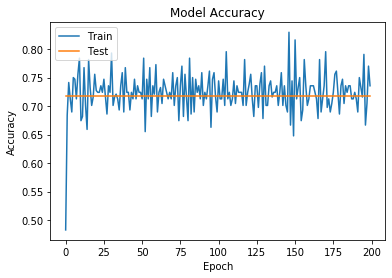

In [0]:
plt.clf()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train', 'Test'], loc="upper left")
plt.savefig('model2-acc.png')